In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

# Cluster visualisation

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
import numpy as np
from pyspark.ml.feature import PCA as PCAml

def plot_clustering(data,predictions):
    pca = PCAml(k=2, inputCol="features", outputCol="pca")
    pca_model = pca.fit(data)
    pca_transformed = pca_model.transform(data)

    X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
    X_pca = np.array(X_pca)
    cluster_assignment = np.array(predictions.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
    countries = np.array(predictions.rdd.map(lambda row: row.Country).collect())

    pca_data = np.hstack((X_pca,cluster_assignment))
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
    pca_df['cluster_assignment'] = pca_df['cluster_assignment'].astype(int)

    sns.set(style="whitegrid", rc={'figure.figsize':(16,9)})
    sns.scatterplot(data=pca_df, x="1st_principal", y="2nd_principal", hue="cluster_assignment", palette="tab10").legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    annotations = []
    for i, point in pca_df.iterrows():
        annotations.append(plt.annotate(countries[i], (point['1st_principal'], point['2nd_principal'])))
    adjust_text(annotations)
    plt.show()

In [8]:
import numpy as np
from pyspark.sql import functions as F
tFile="data\\netflix-subscription.csv"
data = spark.read.csv(tFile,header=True, inferSchema=True)
data.toPandas()

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26
1,au,Australia,6114,4050,2064,7.84,12.12,16.39
2,at,Austria,5640,3779,1861,9.03,14.67,20.32
3,be,Belgium,4990,3374,1616,10.16,15.24,20.32
4,bo,Bolivia,4991,3155,1836,7.99,10.99,13.99
...,...,...,...,...,...,...,...,...
60,ua,Ukraine,5336,3261,2075,5.64,8.46,11.29
61,gb,United Kingdom,6643,4551,2092,7.91,13.20,18.48
62,us,United States,5818,3826,1992,8.99,13.99,17.99
63,uy,Uruguay,4989,3154,1835,8.99,12.99,15.99


# Convert Data into features

In [9]:
from pyspark.ml.feature import VectorAssembler

columns = ["Total_Library_Size", "Num_TV_Shows", "Num_Movies","Cost_Per_Month_Basic", "Cost_Per_Month_Standard", "Cost_Per_Month_Premium"]
assembler = VectorAssembler(
    inputCols= columns,
    outputCol="features")

data = assembler.transform(data)
data.toPandas().head(2)

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium,features
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,"[4760.0, 3154.0, 1606.0, 3.74, 6.3, 9.26]"
1,au,Australia,6114,4050,2064,7.84,12.12,16.39,"[6114.0, 4050.0, 2064.0, 7.84, 12.12, 16.39]"


# K-Means model

In [10]:
from pyspark.ml.clustering import KMeans
num_clusters = 3
# Train KMeans model
kmeans = KMeans(k=num_clusters, seed=1)
model = kmeans.fit(data)

# Predict cluster assignments
predictions = model.transform(data)
predictions.toPandas().head(2)

,Country_Code,Country,Total_Library_Size,Num_TV_Shows,Num_Movies,Cost_Per_Month_Basic,Cost_Per_Month_Standard,Cost_Per_Month_Premium,features,prediction
0,ar,Argentina,4760,3154,1606,3.74,6.30,9.26,"[4760.0, 3154.0, 1606.0, 3.74, 6.3, 9.26]",2
1,au,Australia,6114,4050,2064,7.84,12.12,16.39,"[6114.0, 4050.0, 2064.0, 7.84, 12.12, 16.39]",1


In [11]:
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)


Cluster 0
['Croatia', 'Finland', 'Indonesia', 'Liechtenstein', 'Moldova', 'San Marino']
Cluster 1
['Australia', 'Bulgaria', 'Canada', 'Czechia', 'Estonia', 'Gibraltar', 'Hungary', 'Iceland', 'India', 'Ireland', 'Latvia', 'Lithuania', 'Malaysia', 'Monaco', 'New Zealand', 'Philippines', 'Singapore', 'Slovakia', 'United Kingdom', 'United States']
Cluster 2
['Argentina', 'Austria', 'Belgium', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Ecuador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Israel', 'Italy', 'Japan', 'Mexico', 'Netherlands', 'Norway', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'Uruguay', 'Venezuela']


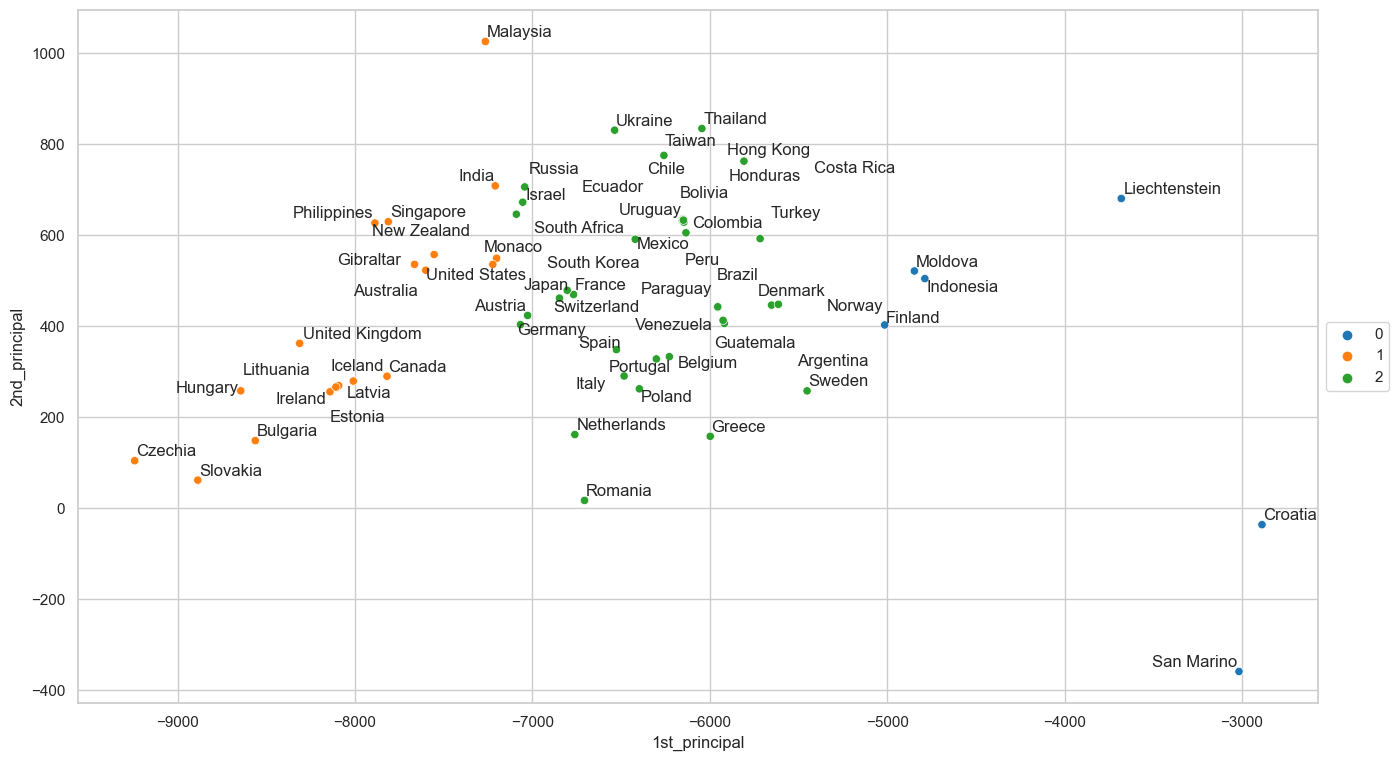

In [42]:
plot_clustering(data, predictions)

# Gaussian Mixture Model (GMM) Clustering

In [44]:
from pyspark.ml.clustering import GaussianMixture

# Train GMM model
gmm = GaussianMixture(k=num_clusters, seed=1)
model = gmm.fit(data)

# make predictions on the test data
predictions = model.transform(data)

In [45]:
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)

Cluster 0
['Croatia', 'Norway', 'San Marino']
Cluster 1
['Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Ecuador', 'Estonia', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Liechtenstein', 'Lithuania', 'Malaysia', 'Mexico', 'Moldova', 'Monaco', 'Netherlands', 'New Zealand', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovakia', 'South Korea', 'Spain', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay', 'Venezuela']
Cluster 2
['Denmark', 'India', 'South Africa', 'Sweden']


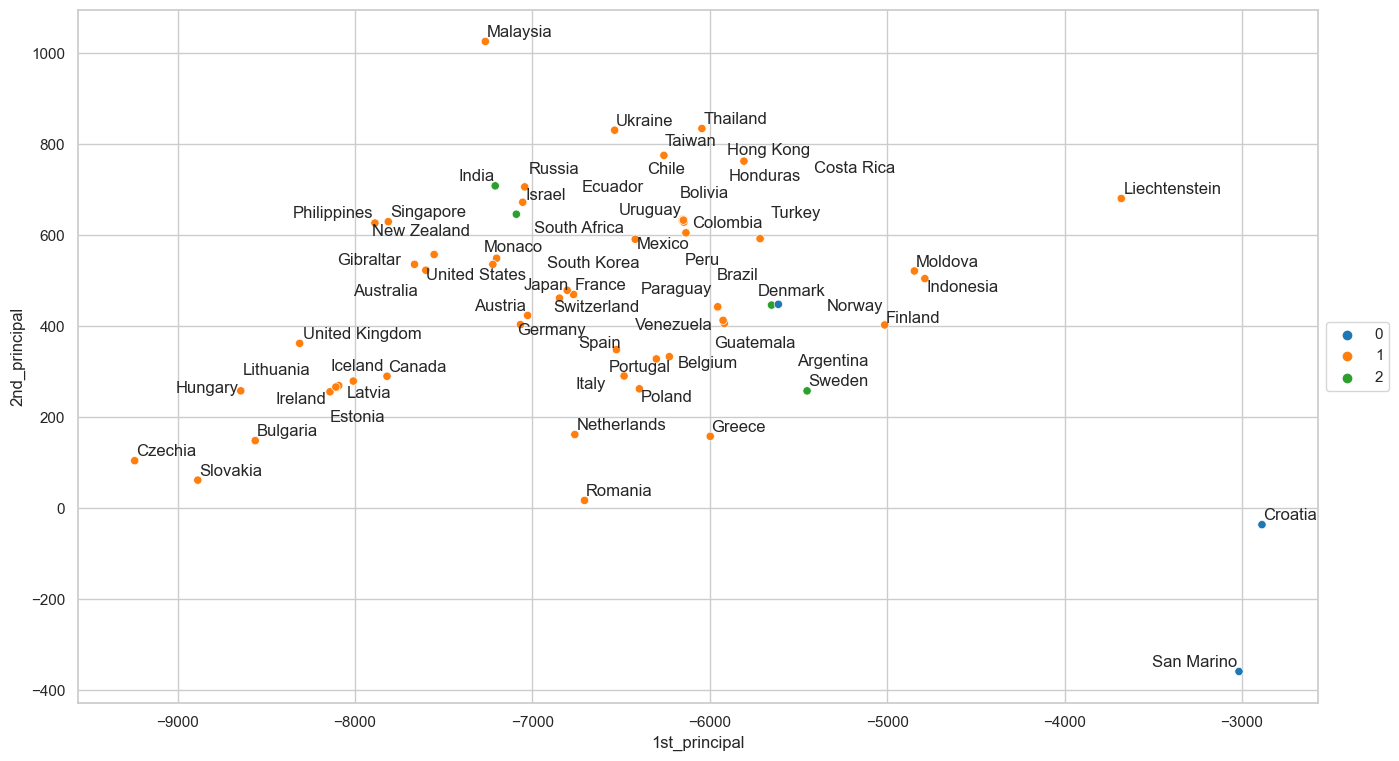

In [46]:
plot_clustering(data, predictions)

# Hierarchical Clustering
Bisecting k-means is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

Bisecting K-means can often be much faster than regular K-means, but it will generally produce a different clustering.

In [47]:
from pyspark.ml.clustering import BisectingKMeans
bkm =BisectingKMeans(featuresCol='features', k=3, distanceMeasure="euclidean") 
model=bkm.fit(data)
predictions=model.transform(data)

In [48]:
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)

Cluster 0
['Croatia', 'Finland', 'Indonesia', 'Liechtenstein', 'Moldova', 'San Marino']
Cluster 1
['Argentina', 'Belgium', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Ecuador', 'Greece', 'Guatemala', 'Honduras', 'Hong Kong', 'Italy', 'Mexico', 'Norway', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'South Korea', 'Spain', 'Sweden', 'Taiwan', 'Thailand', 'Turkey', 'Ukraine', 'Uruguay', 'Venezuela']
Cluster 2
['Australia', 'Austria', 'Bulgaria', 'Canada', 'Czechia', 'Estonia', 'France', 'Germany', 'Gibraltar', 'Hungary', 'Iceland', 'India', 'Ireland', 'Israel', 'Japan', 'Latvia', 'Lithuania', 'Malaysia', 'Monaco', 'Netherlands', 'New Zealand', 'Philippines', 'Romania', 'Russia', 'Singapore', 'Slovakia', 'South Africa', 'Switzerland', 'United Kingdom', 'United States']


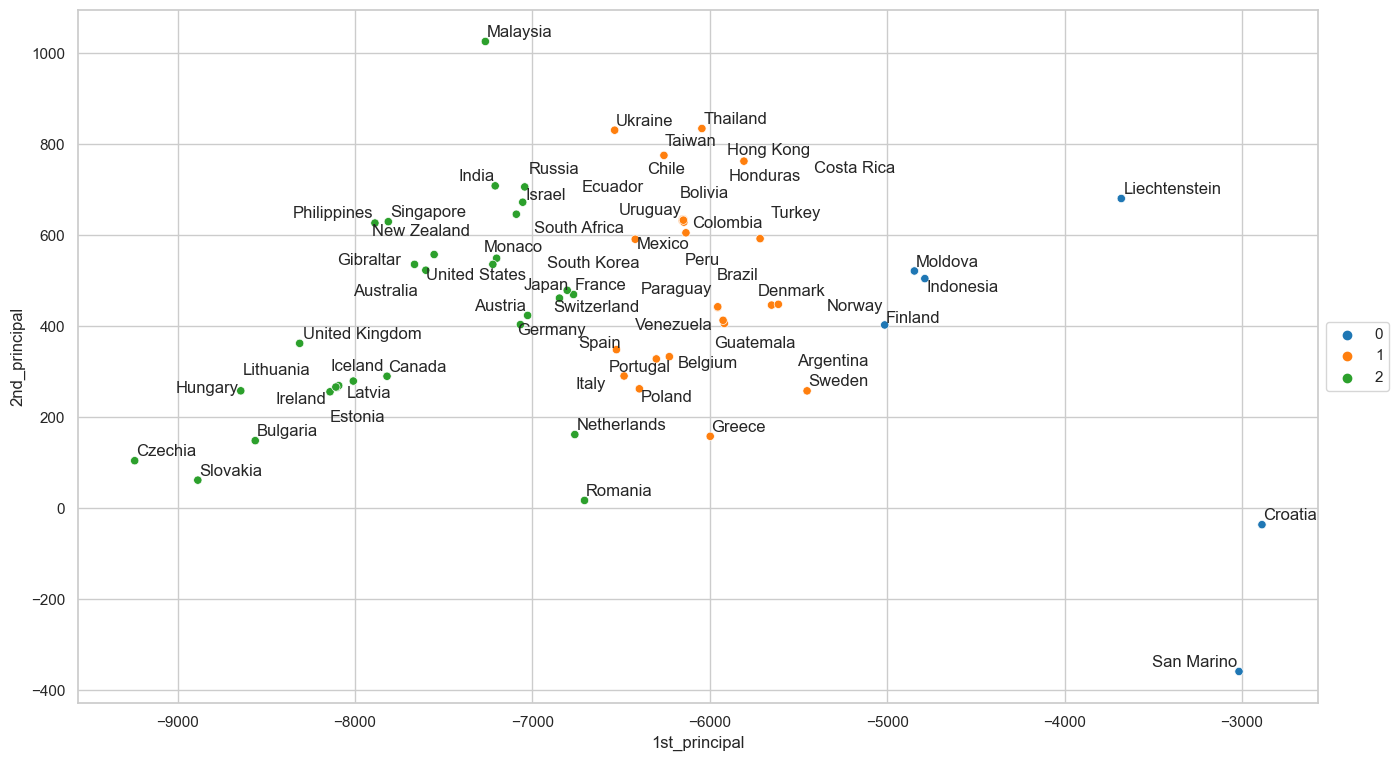

In [49]:
plot_clustering(data,predictions)

Cluster 0
['Austria', 'Belgium', 'Canada', 'Estonia', 'Germany', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Poland', 'Portugal', 'Spain', 'Sweden', 'United Kingdom']
Cluster 1
['Bulgaria', 'Croatia', 'Czechia', 'Greece', 'Netherlands', 'Romania', 'Slovakia']
Cluster 2
['San Marino']


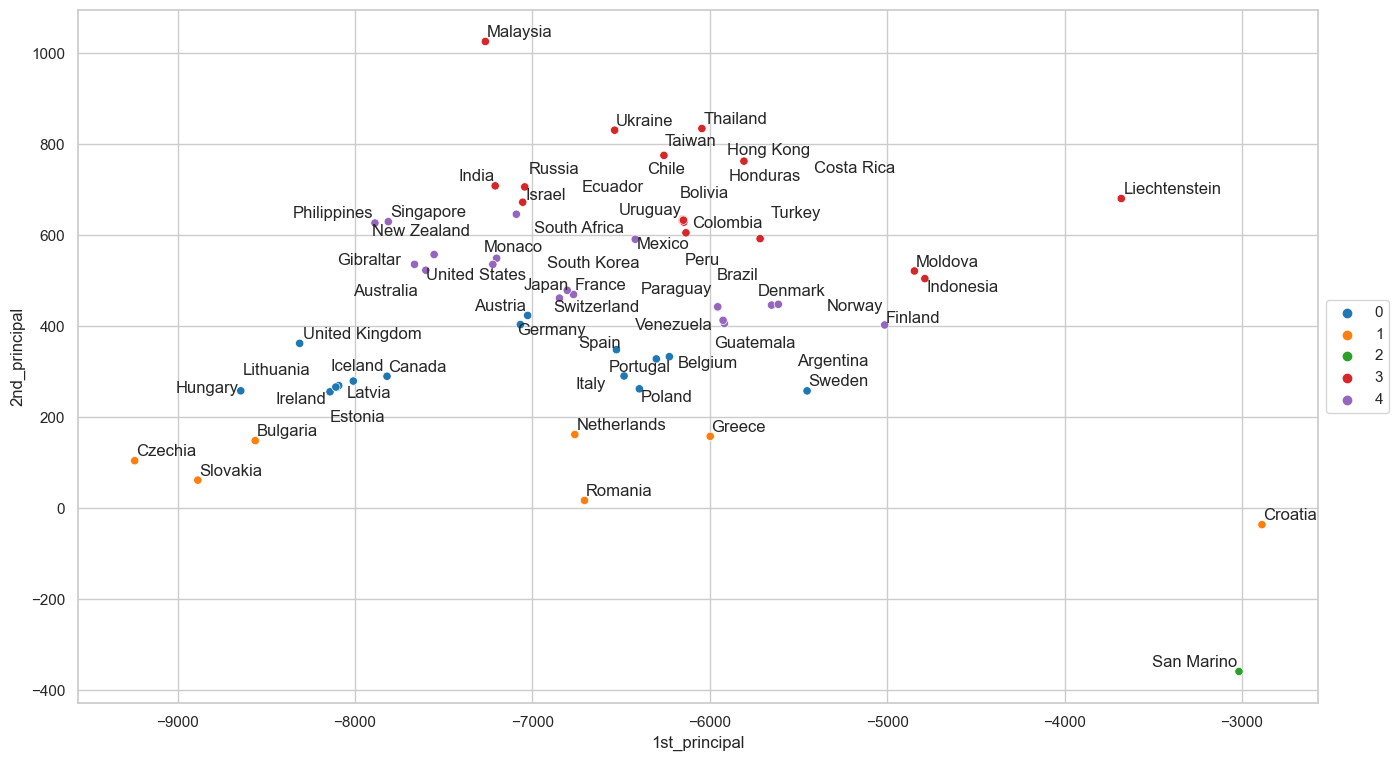

In [50]:
from pyspark.ml.clustering import BisectingKMeans
bkm =BisectingKMeans(featuresCol='features', k=5, distanceMeasure="cosine") 
model=bkm.fit(data)
predictions=model.transform(data)
for i in range(num_clusters):
    print("Cluster",i)
    c = predictions.filter(F.col("prediction")== i).select("Country").rdd.map(tuple).map(lambda x: x[0]).collect()
    print(c)
plot_clustering(data,predictions)

In [51]:
# # Import TSNE
# from sklearn.manifold import TSNE
# # Create a TSNE instance: model
# model = TSNE(learning_rate=50)
# # Apply fit_transform to normalized_movements: tsne_features
# tsne_features = model.fit_transform(normalized_movements)
# # Select the 0th feature: xs
# xs = tsne_features[:,0]
# # Select the 1th feature: ys
# ys = tsne_features[:,1]
# # Scatter plot
# plt.scatter(xs,ys,alpha=0.5)
# # Annotate the points
# for x, y, company in zip(xs, ys, companies):
#     plt.annotate(company, (x, y), fontsize=5, alpha=0.75)
# plt.show()